# GAN Time Series Augmentation

Other ideas:
* PCA Score
* Random forest on real vs generated samples
* SoftDTW on GAN

In [ ]:
# Data preprocessing
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Data augmentation
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import random
from soft_dtw import SoftDTW

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Classification and plotting
import AutomatingClassification as automator
import matplotlib.pyplot as plt

## Read in and prepare the data

In [ ]:
def readArffToDf(fileName):
    data = arff.loadarff(fileName)
    return pd.DataFrame(data[0])

In [ ]:
train = readArffToDf('Earthquakes_TRAIN.arff')
test = readArffToDf('Earthquakes_TEST.arff')

In [ ]:
train['target'] = train['target'].astype(int)
test['target'] = test['target'].astype(int)

### Leaving the classes together for time series classification

In [ ]:
trainX = train.drop(columns=['target'])
trainY = train['target']

testX = test.drop(columns=['target'])
testY = test['target']

### Separating out our classes for data augmentation

In [ ]:
trainLabel1 = train [ train['target'] == 1 ]
trainLabel0 = train [ train['target'] == 0 ]

In [ ]:
trainLabel1X = trainLabel1.drop(columns=['target'])
trainLabel1Y = trainLabel1['target']

trainLabel0X = trainLabel0.drop(columns=['target'])
trainLabel0Y = trainLabel0['target']

## Building the model

In [ ]:
class EarthquakeDataset(Dataset):

  def __init__(self, data):
    """
    The input 'data' can be either a two-dimensional numpy array or a dataframe.
    """
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if type(self.data) == np.ndarray:
      row = self.data[idx]
    else:
      row = self.data.iloc[idx]
    return torch.Tensor(row)

In [ ]:
class Generator(nn.Module):

    def __init__(self):
      super(Generator, self).__init__()

      self.model = torch.nn.Sequential(
            torch.nn.Linear(512, 750),
            torch.nn.ReLU(),
            torch.nn.Linear(750, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 512)
        )

    def forward(self, input):
      return self.model(input)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
      super(Discriminator, self).__init__()

      self.model = torch.nn.Sequential(
            torch.nn.Linear(512, 300),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.50),
            torch.nn.Linear(300, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.50),
            torch.nn.Linear(150, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
      return self.model(input)

In [ ]:
def getAccuracy(probs, labels):
  """
  Function returns the accuracy between the probabilities and inputs.
  """
  labels = labels.flatten()
  probs = probs.flatten()
  guesses = (probs >= 0.5).astype('float')
  return sum(guesses == labels) / len(guesses)

In [ ]:
def generateMixedLabels(probs, batchSize):
  """
  The function generates labels for training the discriminator.
  The idea is to give the discriminator false information
  so that it can't learn too quickly.
  The probs parameter is a list containing the probability of 0 and 1.
  """
  sampleNumbers = np.random.choice([0, 1], (batchSize, 1), p=probs)
  return torch.Tensor(sampleNumbers)

def generateConsistentLabels(one, batchSize):
  """
  The function simply generates a tensor of all ones or all zeros.
  Set 'one' to True to generate all ones.
  """
  if one:
    return torch.full( (batchSize,1), 1, dtype=torch.float)
  else:
    return torch.full( (batchSize,1), 0, dtype=torch.float)

In [ ]:
def setLowerBoundOnArray(arr, lowerBound):
  """
  This function is useful for data augmentation methods.
  We know that values never go below about 0.9 in practice.
  Thus, we can cap the lowest values in our augmentated data.
  """
  arr[arr < lowerBound] = lowerBound

In [ ]:
def standardizeData(dataset):
  scaler = StandardScaler()
  return scaler.fit_transform(dataset)

In [1]:
class DataAugmenter:

  def __init__(self, df):
    self.dataset = EarthquakeDataset(df)
    self.discriminator = Discriminator()
    self.generator = Generator()


  def trainModel(self, bce, epochs, batchSize, lrD, lrG, mixedLabelPct, verbose=False):

    self.discriminator.train()
    self.generator.train()

    # Track loss over time.
    self.discriminatorLosses = []
    self.discriminatorAccuracies = []
    self.generatorLosses = []
    self.generatorAccuracies = []
    discriminatorLossSum = 0
    generatorLossSum = 0

    # Create the necessary objects.
    self.batchSize = batchSize
    self.dataloader = DataLoader(self.dataset, batch_size=batchSize, shuffle=True)
    optimizerD = optim.Adam(params=self.discriminator.parameters(), lr=lrD)
    optimizerG = optim.Adam(params=self.generator.parameters(), lr=lrG)

    # Create the loss function.
    if bce:
      criterion = nn.BCELoss()
    else:
      criterion = SoftDTW(gamma=1.0, normalize=True)

    for epoch in range(epochs):
      mixedLabelPct *= 1
      remainderPct = 1 - mixedLabelPct

      # For each batch in the dataloader
      for i, data in enumerate(self.dataloader):

          # Create real and fake labels for training based on the size of the current batch.
          currentBatchSize = len(data)
          # print('Mixed label percent: {:.2%}'.format(mixedLabelPct))
          discrimMixedRealLabels = generateMixedLabels([mixedLabelPct,remainderPct], currentBatchSize)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

          #### Train with all-real batch.

          self.discriminator.zero_grad()

          # Calculate loss on all-real batch and adjust gradients.
          output = self.discriminator(data)
          realError = criterion(output, discrimMixedRealLabels)
          realError.backward(retain_graph=True)

          # print('Discriminator classification on real data')
          # print('input: ' + str(data))
          # print('output: ' + str(output))
          # print('real label: ' + str(realLabel))
          # print('real error: ' + str(realError))

          # Calculate accuracy for reporting purposes.
          probs = output.detach().numpy()
          labels = discrimMixedRealLabels.detach().numpy()
          realAcc = getAccuracy(probs, labels)


          #### Train with all-fake batch

          fakeLabel = generateConsistentLabels(False, currentBatchSize)

          # Generate fake data from random input. 
          # The same number of samples as the real data are used.
          noise = torch.randn( (currentBatchSize,512) )
          fakeData = self.generator(noise)

          # Classify the fake data and then perform backpropagation on the loss.
          output = self.discriminator(fakeData)
          fakeError = criterion(output, fakeLabel)
          fakeError.backward(retain_graph=True)
          errD = realError + fakeError
          optimizerD.step()

          # print('Discriminator classification on fake data')
          # print('input noise: ' + str(noise.shape))
          # print('fake generated data: ' + str(fakeData.shape))
          # print('fake label: ' + str(fakeLabel.shape))
          # print('output: ' + str(output.shape))
          # print('fake error: ' + str(fakeError))

          # Calculate accuracy for reporting purposes.
          probs = output.detach().numpy()
          labels = fakeLabel.detach().numpy()
          fakeAcc = getAccuracy(probs, labels)

          discrimAcc = (realAcc + fakeAcc) / 2

          # Save the results for plotting.
          realErrorFloat = realError.item()
          fakeErrorFloat = fakeError.item()
          totalErrorFloat = (realErrorFloat + fakeErrorFloat) / 2
          self.discriminatorLosses.append(totalErrorFloat)
          self.discriminatorAccuracies.append(discrimAcc)

          # Calculate average values.
          discriminatorLossSum += totalErrorFloat

          # Optionally report on the current iteration.
          if verbose:
            dRealS = 'Discriminator real error: {:.3f}'.format(realErrorFloat)
            dFakeS = 'Discriminator fake error: {:.3f}'.format(fakeErrorFloat)
            dTotalS = 'Discriminator total error: {:.3f}'.format(totalErrorFloat)
            print(dRealS)
            print(dFakeS)
            print(dTotalS)


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

          realLabel = generateConsistentLabels(True, currentBatchSize)

          self.generator.zero_grad()

          # Since we just updated D, perform another forward pass of all-fake batch through D.
          output = self.discriminator(fakeData)

          # Calculate the generator's loss and perform backpropogation.
          errorG = criterion(output, realLabel)

          # print('fake data: ' + str(fakeData.shape))
          # print('output: ' + str(output.shape))
          # print('error: ' + str(errorG.shape))

          errorG.backward()
          optimizerG.step()

          # Calculate the accuracy for reporting purposes.
          probs = output.detach().numpy()
          labels = realLabel.detach().numpy()
          gAcc = getAccuracy(probs, labels)

          # Save the results for plotting.
          gErrorFloat = errorG.item()
          self.generatorLosses.append(gErrorFloat)
          self.generatorAccuracies.append(gAcc)

          # Calculate average results.
          generatorLossSum += gErrorFloat

          # Optionally report on the current iteration.
          if verbose:
            gRealS = 'Generator error: {:.3f}'.format(gErrorFloat)
            print(gRealS, end='\n\n')

      # Report on epoch accuracy.
      averageDiscrimLoss = discriminatorLossSum / len(self.dataloader)
      averageGenLoss = generatorLossSum / len(self.dataloader)
      epochStr = 'Epoch {}: {:.3f} & {:.3f}'.format(epoch, averageDiscrimLoss, averageGenLoss)
      print(epochStr)
      
      # Zero out the losses.
      discriminatorLossSum = 0
      generatorLossSum = 0

      # Plot what augmented data currently looks like against real data.
      if epoch % 50 == 0:
        self.plotRealAgainstAugmentedData(True)


  def plotLossOverTime(self):
    plt.figure(figsize=(13,7))
    plt.plot(self.discriminatorLosses, label='Discriminator')
    plt.plot(self.generatorLosses, label='Generator')
    plt.legend(loc='best')
    plt.title('GAN loss over time')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')


  def plotAccuracyOverTime(self):
    plt.figure(figsize=(13,7))
    plt.plot(self.discriminatorAccuracies, label='Discriminator')
    plt.plot(self.generatorAccuracies, label='Generator')
    plt.legend(loc='best')
    plt.title('GAN accuracy over time')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')


  def generateAugmentedData(self, setLowerBound):
    self.generator.eval()
    with torch.no_grad():
      noise = torch.randn( (self.batchSize,512) )
      data = self.generator(noise).detach().numpy()
      self.generator.train()
      if setLowerBound:
        setLowerBoundOnArray(data, -0.9)
      return list(data[0])


  def generateAugmentedDataset(self, nObservations, setLowerBound):
    augmentedData = []
    for i in range(nObservations):
      data = self.generateAugmentedData(setLowerBound)
      augmentedData.append(data)
    augmentedData = np.array(augmentedData)
    scaler = StandardScaler()
    return standardizeData(augmentedData)


  def plotRealAgainstAugmentedData(self, setLowerBound):
    # Generate the data.
    dataLength = len(self.dataset)
    index = random.randint(0, dataLength-1)
    real = self.dataset[index]
    augmented = self.generateAugmentedData(setLowerBound)

    # Plot the data.
    figure, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(13,7))
    ax1.plot(real)
    ax1.set_title('Real data')
    ax2.plot(augmented)
    ax2.set_title('Augmented data')
    plt.show()


## Training the model for both classes

Note: For cross entropy loss function 600 epochs works well with a learning rate of 0.01 on both, a permanent mixed signal of 0.2, and a batch size of 20.

Epoch 0: 3.215 & 3.304


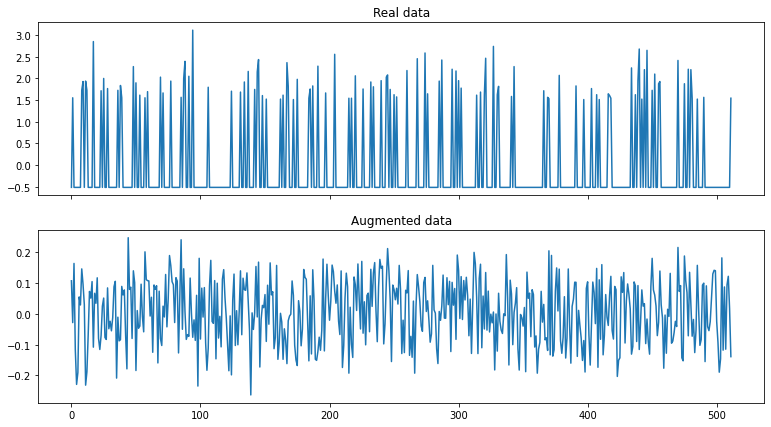

Epoch 1: 0.759 & 2.047
Epoch 2: 0.725 & 0.893
Epoch 3: 0.660 & 1.067
Epoch 4: 0.588 & 1.152
Epoch 5: 0.776 & 0.895
Epoch 6: 0.466 & 1.152
Epoch 7: 0.791 & 1.480
Epoch 8: 0.470 & 1.495
Epoch 9: 0.442 & 2.155
Epoch 10: 0.490 & 2.783
Epoch 11: 0.470 & 2.711
Epoch 12: 0.411 & 2.481
Epoch 13: 0.376 & 2.588
Epoch 14: 0.667 & 2.423
Epoch 15: 0.572 & 3.060
Epoch 16: 0.459 & 5.246
Epoch 17: 0.534 & 4.226
Epoch 18: 0.441 & 4.136
Epoch 19: 0.632 & 5.216
Epoch 20: 0.679 & 5.379
Epoch 21: 0.616 & 4.583
Epoch 22: 0.450 & 4.344
Epoch 23: 0.476 & 4.706
Epoch 24: 0.452 & 7.181
Epoch 25: 0.638 & 6.299
Epoch 26: 0.527 & 7.885
Epoch 27: 0.578 & 10.598
Epoch 28: 0.660 & 5.006
Epoch 29: 0.607 & 6.532
Epoch 30: 0.453 & 6.797
Epoch 31: 0.355 & 5.834
Epoch 32: 0.319 & 6.041
Epoch 33: 0.513 & 6.667
Epoch 34: 0.452 & 7.188
Epoch 35: 0.437 & 3.700
Epoch 36: 0.515 & 4.402
Epoch 37: 0.503 & 3.220
Epoch 38: 0.898 & 5.546
Epoch 39: 0.697 & 8.008
Epoch 40: 0.545 & 3.494
Epoch 41: 0.594 & 4.001
Epoch 42: 0.505 & 5.316


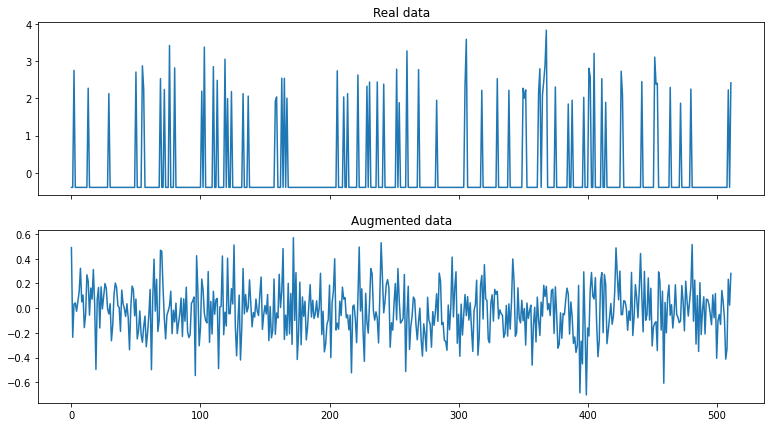

Epoch 51: 0.612 & 5.574
Epoch 52: 0.431 & 4.902
Epoch 53: 0.459 & 6.790
Epoch 54: 0.533 & 6.207
Epoch 55: 0.470 & 6.606
Epoch 56: 0.795 & 8.433
Epoch 57: 0.426 & 8.074
Epoch 58: 0.393 & 8.655
Epoch 59: 0.396 & 8.372
Epoch 60: 0.439 & 7.832
Epoch 61: 0.409 & 9.686
Epoch 62: 0.424 & 13.945
Epoch 63: 0.426 & 14.854
Epoch 64: 0.504 & 13.775
Epoch 65: 0.460 & 13.462
Epoch 66: 0.428 & 8.743
Epoch 67: 0.438 & 9.294
Epoch 68: 0.326 & 10.605
Epoch 69: 0.530 & 11.711
Epoch 70: 0.333 & 13.015
Epoch 71: 0.366 & 10.673
Epoch 72: 0.373 & 12.773
Epoch 73: 0.556 & 10.983
Epoch 74: 0.357 & 9.067
Epoch 75: 0.415 & 11.585
Epoch 76: 1.145 & 15.561
Epoch 77: 2.344 & 18.546
Epoch 78: 0.585 & 17.352
Epoch 79: 0.695 & 22.862
Epoch 80: 0.406 & 25.358
Epoch 81: 0.449 & 13.184
Epoch 82: 0.346 & 13.104
Epoch 83: 0.489 & 8.845
Epoch 84: 1.435 & 11.527
Epoch 85: 0.415 & 14.935
Epoch 86: 0.422 & 10.547
Epoch 87: 0.274 & 11.477
Epoch 88: 0.508 & 10.708
Epoch 89: 0.259 & 9.224
Epoch 90: 0.448 & 14.085
Epoch 91: 0.414 

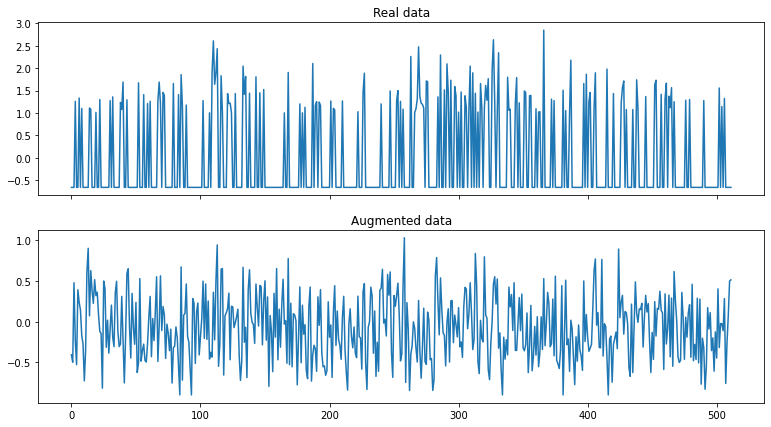

Epoch 101: 0.510 & 8.950
Epoch 102: 0.410 & 9.165
Epoch 103: 0.484 & 9.211
Epoch 104: 0.677 & 6.468
Epoch 105: 5.702 & 13.603
Epoch 106: 1.565 & 12.583
Epoch 107: 0.996 & 1.685
Epoch 108: 0.744 & 36.807
Epoch 109: 0.427 & 41.601
Epoch 110: 1.418 & 23.943
Epoch 111: 0.357 & 13.188
Epoch 112: 2.294 & 8.461
Epoch 113: 1.212 & 14.483
Epoch 114: 1.501 & 20.909
Epoch 115: 1.422 & 25.119
Epoch 116: 0.555 & 22.541
Epoch 117: 0.360 & 26.997
Epoch 118: 0.613 & 24.381
Epoch 119: 0.571 & 17.792
Epoch 120: 0.483 & 15.736
Epoch 121: 1.196 & 19.349
Epoch 122: 0.511 & 22.042
Epoch 123: 0.346 & 15.824
Epoch 124: 0.513 & 16.932
Epoch 125: 1.193 & 13.956
Epoch 126: 1.307 & 14.972
Epoch 127: 0.403 & 12.578
Epoch 128: 1.177 & 13.161
Epoch 129: 1.307 & 20.853
Epoch 130: 0.352 & 16.854
Epoch 131: 0.392 & 12.240
Epoch 132: 1.248 & 9.111
Epoch 133: 0.415 & 15.111
Epoch 134: 0.561 & 14.848
Epoch 135: 0.642 & 14.672
Epoch 136: 0.508 & 13.444
Epoch 137: 0.334 & 11.209
Epoch 138: 0.451 & 14.337
Epoch 139: 0.287 & 

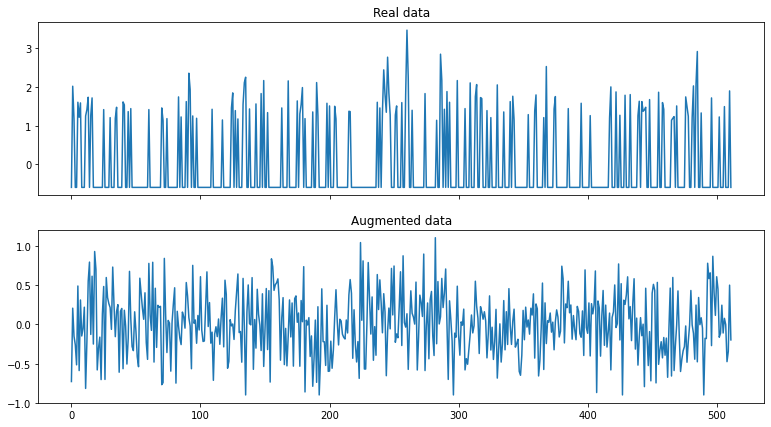

Epoch 151: 0.253 & 26.620
Epoch 152: 0.446 & 26.329
Epoch 153: 1.162 & 25.068
Epoch 154: 0.334 & 17.720
Epoch 155: 0.369 & 12.629
Epoch 156: 0.319 & 12.884
Epoch 157: 0.300 & 13.928
Epoch 158: 0.317 & 13.093
Epoch 159: 0.415 & 11.575
Epoch 160: 0.411 & 10.483
Epoch 161: 0.427 & 11.819
Epoch 162: 0.300 & 11.386
Epoch 163: 0.450 & 10.452
Epoch 164: 0.321 & 8.713
Epoch 165: 0.451 & 13.515
Epoch 166: 0.438 & 18.299
Epoch 167: 0.536 & 17.188
Epoch 168: 1.073 & 12.167
Epoch 169: 0.465 & 13.978
Epoch 170: 0.397 & 9.547
Epoch 171: 0.470 & 9.175
Epoch 172: 0.395 & 12.241
Epoch 173: 0.498 & 19.610
Epoch 174: 0.424 & 21.722
Epoch 175: 0.338 & 27.342
Epoch 176: 0.502 & 25.444
Epoch 177: 0.391 & 27.021
Epoch 178: 0.313 & 22.697
Epoch 179: 0.398 & 19.530
Epoch 180: 0.443 & 21.338
Epoch 181: 0.274 & 17.330
Epoch 182: 0.335 & 13.732
Epoch 183: 0.323 & 14.445
Epoch 184: 0.320 & 12.937
Epoch 185: 0.359 & 13.462
Epoch 186: 0.228 & 15.524
Epoch 187: 0.366 & 14.988
Epoch 188: 0.503 & 12.699
Epoch 189: 0.31

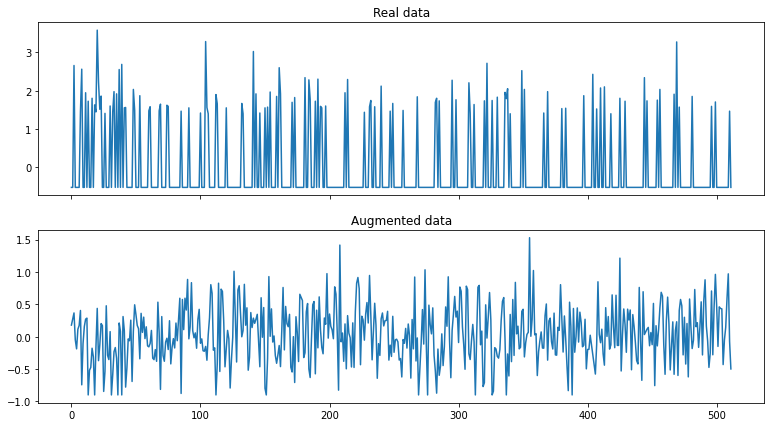

Epoch 201: 0.268 & 27.307
Epoch 202: 0.347 & 35.807
Epoch 203: 0.405 & 36.763
Epoch 204: 0.284 & 30.966
Epoch 205: 0.242 & 29.433
Epoch 206: 0.319 & 25.668
Epoch 207: 0.363 & 30.071
Epoch 208: 0.289 & 27.861
Epoch 209: 0.268 & 27.371
Epoch 210: 0.443 & 21.514
Epoch 211: 0.429 & 13.858
Epoch 212: 0.417 & 13.811
Epoch 213: 0.420 & 15.733
Epoch 214: 0.215 & 22.568
Epoch 215: 0.514 & 25.791
Epoch 216: 0.233 & 26.061
Epoch 217: 0.242 & 28.269
Epoch 218: 0.185 & 28.241
Epoch 219: 0.224 & 28.058
Epoch 220: 1.228 & 25.972
Epoch 221: 0.319 & 22.494
Epoch 222: 0.498 & 19.211
Epoch 223: 0.300 & 13.980
Epoch 224: 0.401 & 13.840
Epoch 225: 0.371 & 13.734
Epoch 226: 0.348 & 15.118
Epoch 227: 0.371 & 17.167
Epoch 228: 0.439 & 14.069
Epoch 229: 0.340 & 15.472
Epoch 230: 0.386 & 16.390
Epoch 231: 0.347 & 12.490
Epoch 232: 0.317 & 12.038
Epoch 233: 0.417 & 17.421
Epoch 234: 0.260 & 15.710
Epoch 235: 0.329 & 13.905
Epoch 236: 0.389 & 19.199
Epoch 237: 0.297 & 25.833
Epoch 238: 0.349 & 26.998
Epoch 239: 0

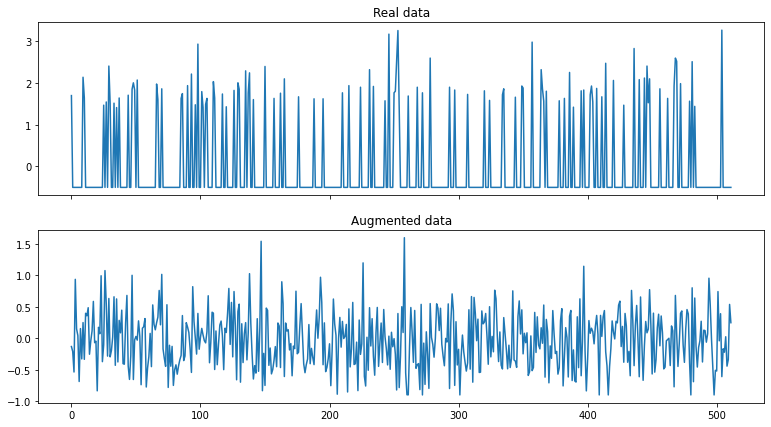

Epoch 251: 0.311 & 23.865
Epoch 252: 0.264 & 23.795
Epoch 253: 0.278 & 24.590
Epoch 254: 0.242 & 24.709
Epoch 255: 0.404 & 20.843
Epoch 256: 0.282 & 25.471
Epoch 257: 0.310 & 24.266
Epoch 258: 0.399 & 25.410
Epoch 259: 0.237 & 23.665
Epoch 260: 0.337 & 23.570
Epoch 261: 0.376 & 19.204
Epoch 262: 0.245 & 17.798
Epoch 263: 0.364 & 20.075
Epoch 264: 0.308 & 21.350
Epoch 265: 0.340 & 22.358
Epoch 266: 0.367 & 18.829
Epoch 267: 0.299 & 19.142
Epoch 268: 0.529 & 22.894
Epoch 269: 0.451 & 22.370
Epoch 270: 0.251 & 16.342
Epoch 271: 0.306 & 19.076
Epoch 272: 0.285 & 18.018
Epoch 273: 0.372 & 16.435
Epoch 274: 0.225 & 15.437
Epoch 275: 1.108 & 15.638
Epoch 276: 0.334 & 21.811
Epoch 277: 0.220 & 28.925
Epoch 278: 0.618 & 33.701
Epoch 279: 0.261 & 34.633
Epoch 280: 0.224 & 32.845
Epoch 281: 0.303 & 30.083
Epoch 282: 0.423 & 28.775
Epoch 283: 0.293 & 26.918
Epoch 284: 0.309 & 28.246
Epoch 285: 0.938 & 28.016
Epoch 286: 0.366 & 14.824
Epoch 287: 0.530 & 15.632
Epoch 288: 0.385 & 12.667
Epoch 289: 0

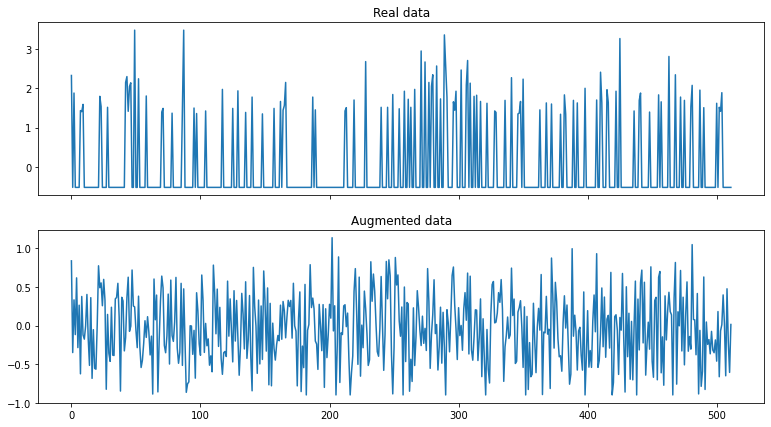

Epoch 301: 0.397 & 25.656
Epoch 302: 0.413 & 24.547
Epoch 303: 0.291 & 25.652
Epoch 304: 0.310 & 19.202
Epoch 305: 0.361 & 21.587
Epoch 306: 0.232 & 29.790
Epoch 307: 0.344 & 39.063
Epoch 308: 0.399 & 34.199
Epoch 309: 0.234 & 34.418
Epoch 310: 0.332 & 27.458
Epoch 311: 0.288 & 32.276
Epoch 312: 0.546 & 30.015
Epoch 313: 0.373 & 21.541
Epoch 314: 0.350 & 14.028
Epoch 315: 0.360 & 11.980
Epoch 316: 0.297 & 14.492
Epoch 317: 0.324 & 18.312
Epoch 318: 0.220 & 17.947
Epoch 319: 0.393 & 22.184
Epoch 320: 1.411 & 15.749
Epoch 321: 1.787 & 20.739
Epoch 322: 0.619 & 20.386
Epoch 323: 0.615 & 11.071
Epoch 324: 0.468 & 10.013
Epoch 325: 0.472 & 10.885
Epoch 326: 0.554 & 10.282
Epoch 327: 0.640 & 9.331
Epoch 328: 0.792 & 8.592
Epoch 329: 0.513 & 5.764
Epoch 330: 2.295 & 4.028
Epoch 331: 0.860 & 5.094
Epoch 332: 0.759 & 4.435
Epoch 333: 0.801 & 3.722
Epoch 334: 0.664 & 2.623
Epoch 335: 0.778 & 1.818
Epoch 336: 0.825 & 1.186
Epoch 337: 0.675 & 2.973
Epoch 338: 0.839 & 0.678
Epoch 339: 0.702 & 2.567

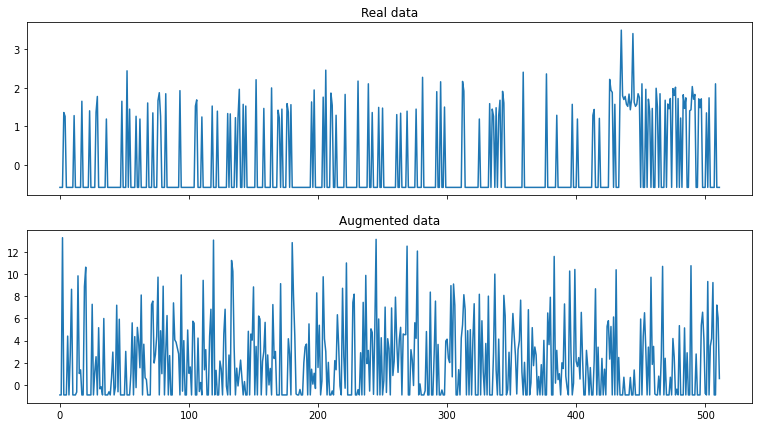

Epoch 351: 0.672 & 2.009
Epoch 352: 0.686 & 1.698
Epoch 353: 3.214 & 1.568
Epoch 354: 6.008 & 0.901
Epoch 355: 0.656 & 10.316
Epoch 356: 1.582 & 1.770
Epoch 357: 0.840 & 0.953
Epoch 358: 0.717 & 0.910
Epoch 359: 0.626 & 1.170
Epoch 360: 0.642 & 1.135
Epoch 361: 1.604 & 1.433
Epoch 362: 0.646 & 0.901
Epoch 363: 0.624 & 1.072
Epoch 364: 0.678 & 0.871
Epoch 365: 0.681 & 1.171
Epoch 366: 0.713 & 1.278
Epoch 367: 0.743 & 1.233
Epoch 368: 0.641 & 1.282
Epoch 369: 1.561 & 0.898
Epoch 370: 0.637 & 1.257
Epoch 371: 0.695 & 0.898
Epoch 372: 0.656 & 1.229
Epoch 373: 0.622 & 0.895
Epoch 374: 3.351 & 1.346
Epoch 375: 9.644 & 1.184
Epoch 376: 4.092 & 11.336
Epoch 377: 0.712 & 16.221
Epoch 378: 0.738 & 3.968
Epoch 379: 0.656 & 0.948
Epoch 380: 0.783 & 0.947
Epoch 381: 1.608 & 0.946
Epoch 382: 0.662 & 0.942
Epoch 383: 0.738 & 0.924
Epoch 384: 1.561 & 0.942
Epoch 385: 0.664 & 2.594
Epoch 386: 0.743 & 0.925
Epoch 387: 0.656 & 0.942
Epoch 388: 0.653 & 0.927
Epoch 389: 0.697 & 0.931
Epoch 390: 1.571 & 0.9

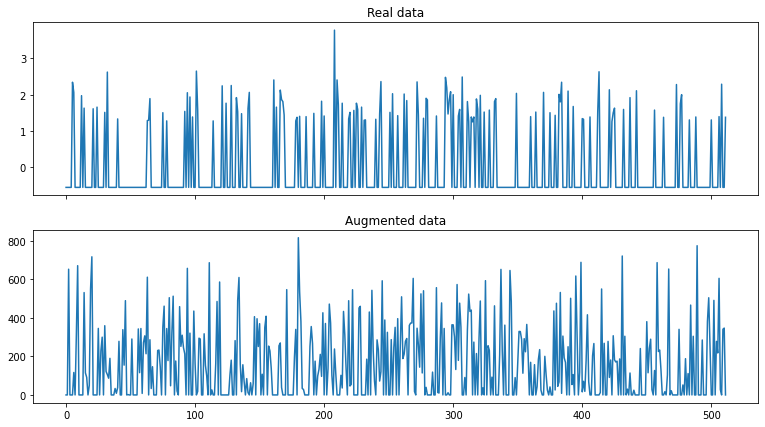

Epoch 401: 25.261 & 0.515
Epoch 402: 30.965 & 0.539
Epoch 403: 23.033 & 0.393
Epoch 404: 19.323 & 21.471
Epoch 405: 15.727 & 0.604
Epoch 406: 23.632 & 0.521
Epoch 407: 28.142 & 2.182
Epoch 408: 11.717 & 20.920
Epoch 409: 1.919 & 0.920
Epoch 410: 0.848 & 0.916
Epoch 411: 0.657 & 2.566
Epoch 412: 0.607 & 2.582
Epoch 413: 1.441 & 0.936
Epoch 414: 0.618 & 0.942
Epoch 415: 0.695 & 2.600
Epoch 416: 0.732 & 0.938
Epoch 417: 0.692 & 0.944
Epoch 418: 8.589 & 0.847
Epoch 419: 17.938 & 0.439
Epoch 420: 26.185 & 0.553
Epoch 421: 31.037 & 0.410
Epoch 422: 19.664 & 17.049
Epoch 423: 25.372 & 0.547
Epoch 424: 30.498 & 0.429
Epoch 425: 24.800 & 0.490
Epoch 426: 15.535 & 18.713
Epoch 427: 1.553 & 9.667
Epoch 428: 2.387 & 5.817
Epoch 429: 4.883 & 0.923
Epoch 430: 3.191 & 2.444
Epoch 431: 5.851 & 0.860
Epoch 432: 0.903 & 0.911
Epoch 433: 1.611 & 0.916
Epoch 434: 2.309 & 0.921
Epoch 435: 4.274 & 0.945
Epoch 436: 1.611 & 0.934
Epoch 437: 4.197 & 0.957
Epoch 438: 0.721 & 0.929
Epoch 439: 0.696 & 0.968
Epoch

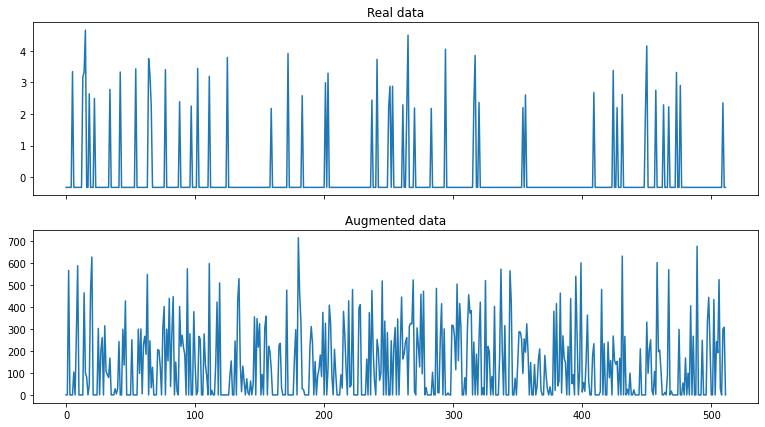

Epoch 451: 0.663 & 0.980
Epoch 452: 0.671 & 2.628
Epoch 453: 0.678 & 2.808
Epoch 454: 1.497 & 0.970
Epoch 455: 2.421 & 0.965
Epoch 456: 0.672 & 0.927
Epoch 457: 1.612 & 0.954
Epoch 458: 1.595 & 0.935
Epoch 459: 0.654 & 0.947
Epoch 460: 0.655 & 0.945
Epoch 461: 0.661 & 0.942
Epoch 462: 1.484 & 0.920
Epoch 463: 0.755 & 0.900
Epoch 464: 0.689 & 0.932
Epoch 465: 0.662 & 0.930
Epoch 466: 0.846 & 2.580
Epoch 467: 0.724 & 0.927
Epoch 468: 0.660 & 0.926
Epoch 469: 0.660 & 0.924
Epoch 470: 0.661 & 0.923
Epoch 471: 0.668 & 0.922
Epoch 472: 0.668 & 0.921
Epoch 473: 0.666 & 0.919
Epoch 474: 0.781 & 0.919
Epoch 475: 0.652 & 0.919
Epoch 476: 1.490 & 2.573
Epoch 477: 0.663 & 0.925
Epoch 478: 0.666 & 0.928
Epoch 479: 0.671 & 0.931
Epoch 480: 0.646 & 0.934
Epoch 481: 0.743 & 0.940
Epoch 482: 0.664 & 2.779
Epoch 483: 0.645 & 0.947
Epoch 484: 0.660 & 0.950
Epoch 485: 0.685 & 0.952
Epoch 486: 0.659 & 0.952
Epoch 487: 0.674 & 0.951
Epoch 488: 0.704 & 0.950
Epoch 489: 0.650 & 0.950
Epoch 490: 0.686 & 0.949


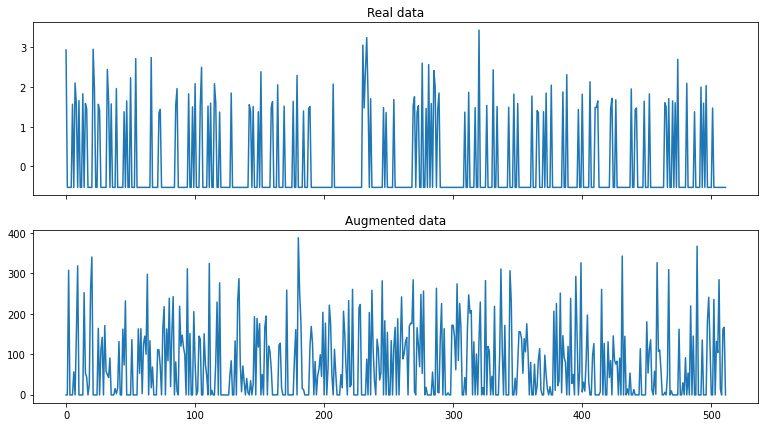

Epoch 501: 0.648 & 0.940
Epoch 502: 0.656 & 0.942
Epoch 503: 0.778 & 0.943
Epoch 504: 0.659 & 0.947
Epoch 505: 0.685 & 0.950
Epoch 506: 0.671 & 0.953
Epoch 507: 0.664 & 0.955
Epoch 508: 1.556 & 0.957
Epoch 509: 0.663 & 2.611
Epoch 510: 0.655 & 0.960
Epoch 511: 0.677 & 0.959
Epoch 512: 0.686 & 0.957
Epoch 513: 1.499 & 0.952
Epoch 514: 0.661 & 0.948
Epoch 515: 1.515 & 0.944
Epoch 516: 0.672 & 0.940
Epoch 517: 2.322 & 0.936
Epoch 518: 0.647 & 0.902
Epoch 519: 2.407 & 0.918
Epoch 520: 2.538 & 0.933
Epoch 521: 1.497 & 0.930
Epoch 522: 2.343 & 0.926
Epoch 523: 0.637 & 0.923
Epoch 524: 0.736 & 0.907
Epoch 525: 0.671 & 0.906
Epoch 526: 1.574 & 0.919
Epoch 527: 0.646 & 0.918
Epoch 528: 0.653 & 0.902
Epoch 529: 0.644 & 0.919
Epoch 530: 1.481 & 0.920
Epoch 531: 2.326 & 0.872
Epoch 532: 2.437 & 0.888
Epoch 533: 3.127 & 0.901
Epoch 534: 2.286 & 0.916
Epoch 535: 1.477 & 0.903
Epoch 536: 0.707 & 0.890
Epoch 537: 1.571 & 0.930
Epoch 538: 1.886 & 0.937
Epoch 539: 0.654 & 0.925
Epoch 540: 0.652 & 0.946


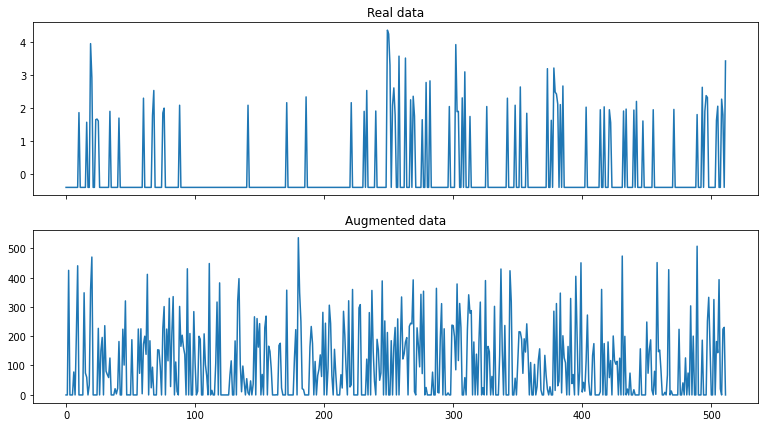

Epoch 551: 1.582 & 0.930
Epoch 552: 0.693 & 0.929
Epoch 553: 0.656 & 0.927
Epoch 554: 0.657 & 0.927
Epoch 555: 0.679 & 0.928
Epoch 556: 1.669 & 0.927
Epoch 557: 0.657 & 0.926
Epoch 558: 0.716 & 0.925
Epoch 559: 0.672 & 0.912
Epoch 560: 0.643 & 0.928
Epoch 561: 0.629 & 0.928
Epoch 562: 0.652 & 0.931
Epoch 563: 0.674 & 0.933
Epoch 564: 0.652 & 0.916
Epoch 565: 1.481 & 0.934
Epoch 566: 0.684 & 0.934
Epoch 567: 0.726 & 0.933
Epoch 568: 0.750 & 0.933
Epoch 569: 0.659 & 0.932
Epoch 570: 1.472 & 0.931
Epoch 571: 0.678 & 0.930
Epoch 572: 0.786 & 0.928
Epoch 573: 1.515 & 0.929
Epoch 574: 0.671 & 0.934
Epoch 575: 1.468 & 0.941
Epoch 576: 2.285 & 0.936
Epoch 577: 0.716 & 0.960
Epoch 578: 0.723 & 0.967
Epoch 579: 0.640 & 0.971
Epoch 580: 1.459 & 0.958
Epoch 581: 3.244 & 0.810
Epoch 582: 9.861 & 3.004
Epoch 583: 0.696 & 2.639
Epoch 584: 0.650 & 0.987
Epoch 585: 0.732 & 0.987
Epoch 586: 0.653 & 0.991
Epoch 587: 2.559 & 0.995
Epoch 588: 1.578 & 0.977
Epoch 589: 1.646 & 0.995
Epoch 590: 0.668 & 0.996


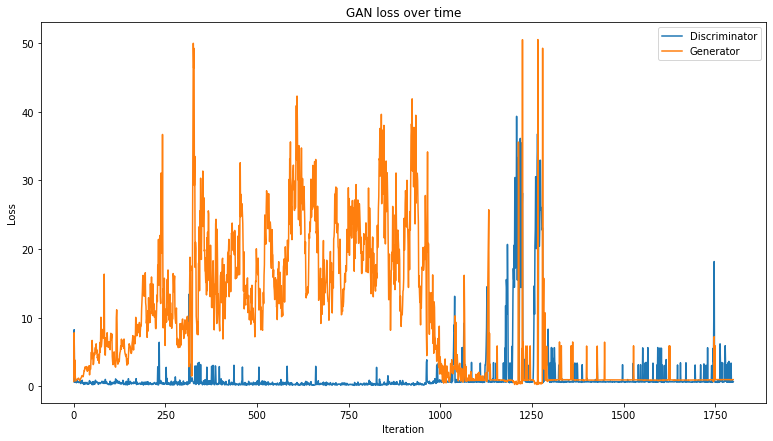

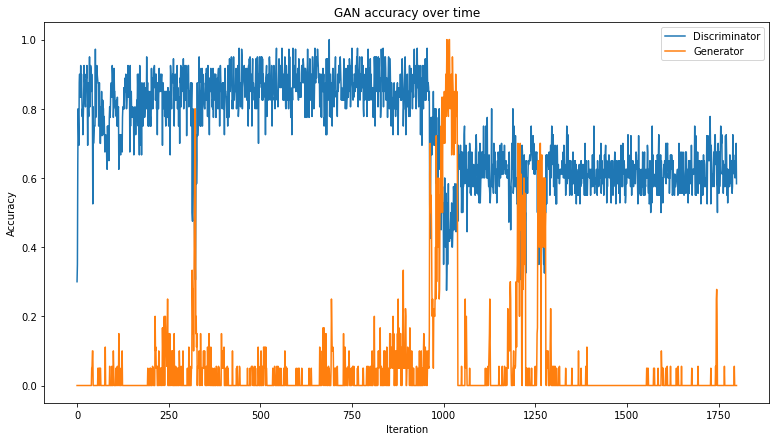

In [ ]:
augmenter1 = DataAugmenter(trainLabel1X)
augmenter1.trainModel(bce=True, epochs=600, batchSize=20, lrD=0.01, lrG=0.01, mixedLabelPct=0.2, verbose=False)
augmenter1.plotLossOverTime()
augmenter1.plotAccuracyOverTime()

Epoch 0: 1.771 & 1.997


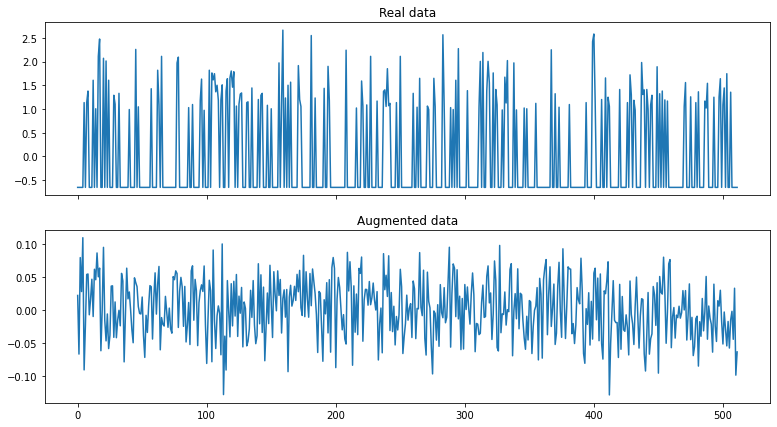

Epoch 1: 0.720 & 1.518
Epoch 2: 0.839 & 2.088
Epoch 3: 0.700 & 4.207
Epoch 4: 0.468 & 3.066
Epoch 5: 0.505 & 3.085
Epoch 6: 0.865 & 3.575
Epoch 7: 1.392 & 4.589
Epoch 8: 0.671 & 5.383
Epoch 9: 0.595 & 4.642
Epoch 10: 0.708 & 4.705
Epoch 11: 0.498 & 3.253
Epoch 12: 0.386 & 4.164
Epoch 13: 0.470 & 4.684
Epoch 14: 0.747 & 5.544
Epoch 15: 0.427 & 10.065
Epoch 16: 0.390 & 7.572
Epoch 17: 1.155 & 6.603
Epoch 18: 0.528 & 5.763
Epoch 19: 1.068 & 7.904
Epoch 20: 0.485 & 9.591
Epoch 21: 0.402 & 6.675
Epoch 22: 0.530 & 4.749
Epoch 23: 0.411 & 7.175
Epoch 24: 0.463 & 8.799
Epoch 25: 0.620 & 7.917
Epoch 26: 0.726 & 10.477
Epoch 27: 0.574 & 7.121
Epoch 28: 0.804 & 7.335
Epoch 29: 0.380 & 9.627
Epoch 30: 0.324 & 12.972
Epoch 31: 0.399 & 8.863
Epoch 32: 0.358 & 9.424
Epoch 33: 0.357 & 12.171
Epoch 34: 0.367 & 11.758
Epoch 35: 0.485 & 12.149
Epoch 36: 0.700 & 2.648
Epoch 37: 1.309 & 0.573
Epoch 38: 3.940 & 0.913
Epoch 39: 5.693 & 4.278
Epoch 40: 1.536 & 36.085
Epoch 41: 8.983 & 15.277
Epoch 42: 9.391 &

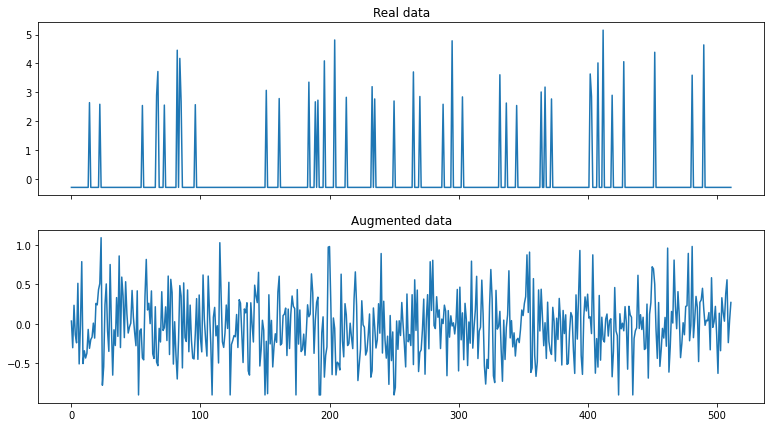

Epoch 51: 1.424 & 42.095
Epoch 52: 1.061 & 48.937
Epoch 53: 1.295 & 45.783
Epoch 54: 4.553 & 45.484
Epoch 55: 4.327 & 43.206
Epoch 56: 2.071 & 33.410
Epoch 57: 0.711 & 19.606
Epoch 58: 0.609 & 15.721
Epoch 59: 2.317 & 11.405
Epoch 60: 4.426 & 10.587
Epoch 61: 2.576 & 5.854
Epoch 62: 7.605 & 3.745
Epoch 63: 1.409 & 3.075
Epoch 64: 1.892 & 13.960
Epoch 65: 1.364 & 6.148
Epoch 66: 3.536 & 14.418
Epoch 67: 1.217 & 49.711
Epoch 68: 0.815 & 21.714
Epoch 69: 1.374 & 8.139
Epoch 70: 0.689 & 5.316
Epoch 71: 1.181 & 4.401
Epoch 72: 1.200 & 3.012
Epoch 73: 6.884 & 2.211
Epoch 74: 14.688 & 3.161
Epoch 75: 13.647 & 1.780
Epoch 76: 9.217 & 1.839
Epoch 77: 1.226 & 1.964
Epoch 78: 2.243 & 1.965
Epoch 79: 2.132 & 3.050
Epoch 80: 2.122 & 1.990
Epoch 81: 0.684 & 3.398
Epoch 82: 0.663 & 1.311
Epoch 83: 0.859 & 2.726
Epoch 84: 1.209 & 2.720
Epoch 85: 0.839 & 3.080
Epoch 86: 0.862 & 1.294
Epoch 87: 1.215 & 1.990
Epoch 88: 4.530 & 2.312
Epoch 89: 2.488 & 1.984
Epoch 90: 0.695 & 1.619
Epoch 91: 0.709 & 2.672


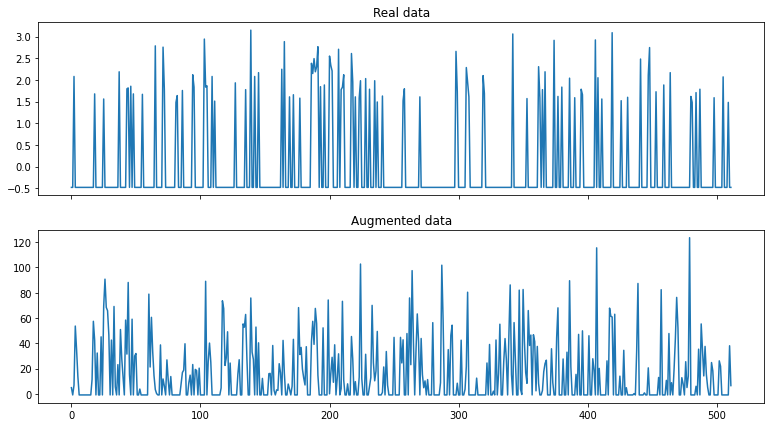

Epoch 101: 0.678 & 1.970
Epoch 102: 0.688 & 1.374
Epoch 103: 0.676 & 1.555
Epoch 104: 0.650 & 2.118
Epoch 105: 0.767 & 2.333
Epoch 106: 0.801 & 0.909
Epoch 107: 0.726 & 1.949
Epoch 108: 1.051 & 1.262
Epoch 109: 0.831 & 0.912
Epoch 110: 0.902 & 0.901
Epoch 111: 0.677 & 0.890
Epoch 112: 0.668 & 1.242
Epoch 113: 0.853 & 0.890
Epoch 114: 9.077 & 1.774
Epoch 115: 2.487 & 10.270
Epoch 116: 0.661 & 1.253
Epoch 117: 1.190 & 1.267
Epoch 118: 3.337 & 1.259
Epoch 119: 2.274 & 3.693
Epoch 120: 6.000 & 0.797
Epoch 121: 6.796 & 1.850
Epoch 122: 12.386 & 0.665
Epoch 123: 7.786 & 5.295
Epoch 124: 0.673 & 1.918
Epoch 125: 0.680 & 0.873
Epoch 126: 0.671 & 1.605
Epoch 127: 0.686 & 0.920
Epoch 128: 0.719 & 1.631
Epoch 129: 0.696 & 2.734
Epoch 130: 0.663 & 4.802
Epoch 131: 0.679 & 1.267
Epoch 132: 0.663 & 0.921
Epoch 133: 0.650 & 0.932
Epoch 134: 0.838 & 0.959
Epoch 135: 0.670 & 0.964
Epoch 136: 0.664 & 1.665
Epoch 137: 0.664 & 1.657
Epoch 138: 0.662 & 0.945
Epoch 139: 0.680 & 1.640
Epoch 140: 0.665 & 0.92

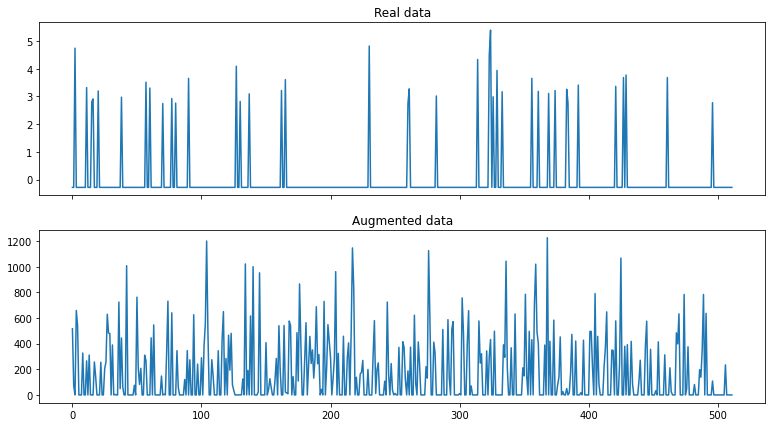

Epoch 151: 0.850 & 0.936
Epoch 152: 0.857 & 1.281
Epoch 153: 0.704 & 1.982
Epoch 154: 0.661 & 0.927
Epoch 155: 0.840 & 1.288
Epoch 156: 0.671 & 1.633
Epoch 157: 0.656 & 1.625
Epoch 158: 0.999 & 1.282
Epoch 159: 1.234 & 1.645
Epoch 160: 0.986 & 2.359
Epoch 161: 0.771 & 0.956
Epoch 162: 0.670 & 0.957
Epoch 163: 0.703 & 1.299
Epoch 164: 0.731 & 1.290
Epoch 165: 0.670 & 1.642
Epoch 166: 0.669 & 0.935
Epoch 167: 0.693 & 1.639
Epoch 168: 0.669 & 0.932
Epoch 169: 0.665 & 1.288
Epoch 170: 1.052 & 0.923
Epoch 171: 0.684 & 0.909
Epoch 172: 0.682 & 0.921
Epoch 173: 0.687 & 0.946
Epoch 174: 0.675 & 0.953
Epoch 175: 0.674 & 0.929
Epoch 176: 0.676 & 0.902
Epoch 177: 0.689 & 0.904
Epoch 178: 0.670 & 0.929
Epoch 179: 0.673 & 0.934
Epoch 180: 0.926 & 1.276
Epoch 181: 0.719 & 0.909
Epoch 182: 0.677 & 1.624
Epoch 183: 0.700 & 1.276
Epoch 184: 0.681 & 0.923
Epoch 185: 0.674 & 1.260
Epoch 186: 0.677 & 1.621
Epoch 187: 0.672 & 1.984
Epoch 188: 0.671 & 0.918
Epoch 189: 0.707 & 1.264
Epoch 190: 0.694 & 0.911


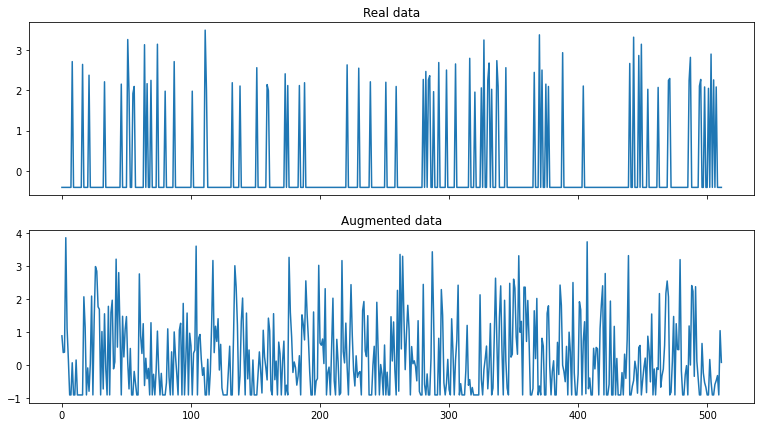

Epoch 201: 0.666 & 1.305
Epoch 202: 0.680 & 1.307
Epoch 203: 0.669 & 0.927
Epoch 204: 0.677 & 1.269
Epoch 205: 0.669 & 1.615
Epoch 206: 0.692 & 1.264
Epoch 207: 0.669 & 0.904
Epoch 208: 0.673 & 1.622
Epoch 209: 0.694 & 0.916
Epoch 210: 0.679 & 1.294
Epoch 211: 0.666 & 0.893
Epoch 212: 0.674 & 1.257
Epoch 213: 0.644 & 3.436
Epoch 214: 4.400 & 0.850
Epoch 215: 6.596 & 3.662
Epoch 216: 0.679 & 0.875
Epoch 217: 0.668 & 1.228
Epoch 218: 0.662 & 0.906
Epoch 219: 0.675 & 0.938
Epoch 220: 0.675 & 1.283
Epoch 221: 0.858 & 1.265
Epoch 222: 0.844 & 0.887
Epoch 223: 1.198 & 0.886
Epoch 224: 1.224 & 0.874
Epoch 225: 5.123 & 0.856
Epoch 226: 0.685 & 1.288
Epoch 227: 0.679 & 0.937
Epoch 228: 0.676 & 0.916
Epoch 229: 0.687 & 0.896
Epoch 230: 0.676 & 0.896
Epoch 231: 0.672 & 0.905
Epoch 232: 0.849 & 0.912
Epoch 233: 0.692 & 0.911
Epoch 234: 0.689 & 0.909
Epoch 235: 0.671 & 0.895
Epoch 236: 0.689 & 0.897
Epoch 237: 0.669 & 0.903
Epoch 238: 0.652 & 0.917
Epoch 239: 0.678 & 0.951
Epoch 240: 0.673 & 0.975


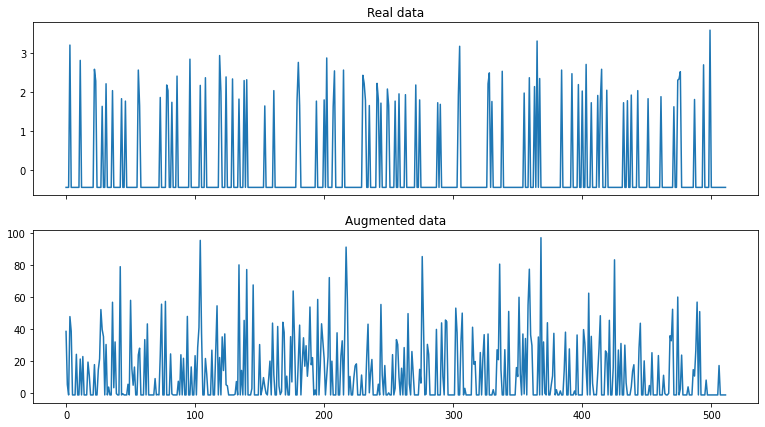

Epoch 251: 0.852 & 1.265
Epoch 252: 0.671 & 0.906
Epoch 253: 0.662 & 0.911
Epoch 254: 0.675 & 1.290
Epoch 255: 0.668 & 0.934
Epoch 256: 0.665 & 0.937
Epoch 257: 0.679 & 0.932
Epoch 258: 0.873 & 0.917
Epoch 259: 0.680 & 1.241
Epoch 260: 0.668 & 0.889
Epoch 261: 0.671 & 0.897
Epoch 262: 0.669 & 0.914
Epoch 263: 0.670 & 0.932
Epoch 264: 0.675 & 0.934
Epoch 265: 0.675 & 0.917
Epoch 266: 0.690 & 0.900
Epoch 267: 0.669 & 0.891
Epoch 268: 0.669 & 0.899
Epoch 269: 0.661 & 0.928
Epoch 270: 0.675 & 0.942
Epoch 271: 0.664 & 1.286
Epoch 272: 0.684 & 0.944
Epoch 273: 0.664 & 0.954
Epoch 274: 0.672 & 0.954
Epoch 275: 0.670 & 0.933
Epoch 276: 0.656 & 0.927
Epoch 277: 0.844 & 0.944
Epoch 278: 0.677 & 0.946
Epoch 279: 0.678 & 1.275
Epoch 280: 0.671 & 0.909
Epoch 281: 0.670 & 0.911
Epoch 282: 0.846 & 0.909
Epoch 283: 0.677 & 0.907
Epoch 284: 1.021 & 2.314
Epoch 285: 0.667 & 0.949
Epoch 286: 0.674 & 0.943
Epoch 287: 0.669 & 1.288
Epoch 288: 0.728 & 0.932
Epoch 289: 0.669 & 0.940
Epoch 290: 0.681 & 0.940


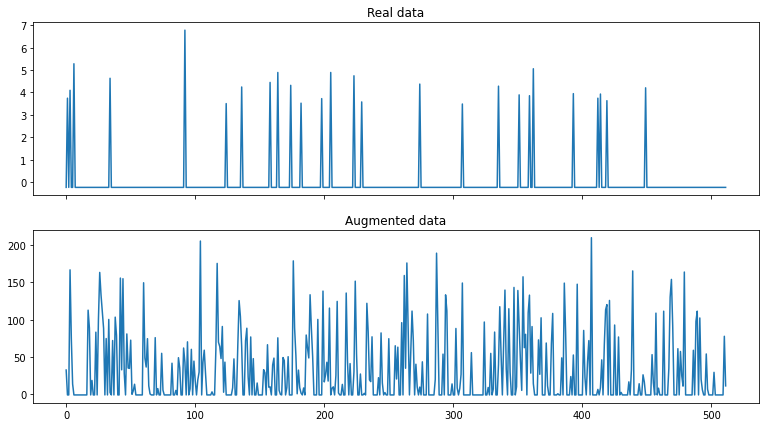

Epoch 301: 0.661 & 1.281
Epoch 302: 0.680 & 0.939
Epoch 303: 0.664 & 0.927
Epoch 304: 0.662 & 0.933
Epoch 305: 0.669 & 0.947
Epoch 306: 0.847 & 0.948
Epoch 307: 0.691 & 0.941
Epoch 308: 0.688 & 0.935
Epoch 309: 0.670 & 1.284
Epoch 310: 0.678 & 0.941
Epoch 311: 0.667 & 1.297
Epoch 312: 0.666 & 0.937
Epoch 313: 0.669 & 0.942
Epoch 314: 0.675 & 0.945
Epoch 315: 0.676 & 0.923
Epoch 316: 1.016 & 0.912
Epoch 317: 0.659 & 0.939
Epoch 318: 0.671 & 0.958
Epoch 319: 0.678 & 0.949
Epoch 320: 0.673 & 0.924
Epoch 321: 0.677 & 0.904
Epoch 322: 0.855 & 0.894
Epoch 323: 0.669 & 1.264
Epoch 324: 0.681 & 0.924
Epoch 325: 0.839 & 0.928
Epoch 326: 0.903 & 0.931
Epoch 327: 0.691 & 0.946
Epoch 328: 0.860 & 0.930
Epoch 329: 0.677 & 1.607
Epoch 330: 0.681 & 0.891
Epoch 331: 0.681 & 1.253
Epoch 332: 0.674 & 0.903
Epoch 333: 0.673 & 0.905
Epoch 334: 0.674 & 0.902
Epoch 335: 0.859 & 0.898
Epoch 336: 0.677 & 0.899
Epoch 337: 0.669 & 0.899
Epoch 338: 0.757 & 0.913
Epoch 339: 0.663 & 0.926
Epoch 340: 0.672 & 0.938


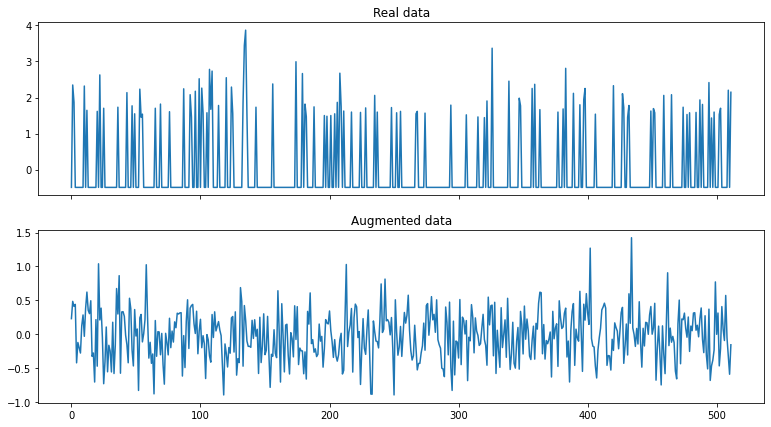

Epoch 351: 0.672 & 0.960
Epoch 352: 0.684 & 0.944
Epoch 353: 0.849 & 0.911
Epoch 354: 0.666 & 0.903
Epoch 355: 0.674 & 0.916
Epoch 356: 0.675 & 1.282
Epoch 357: 0.735 & 0.926
Epoch 358: 0.677 & 0.948
Epoch 359: 0.743 & 0.940
Epoch 360: 0.719 & 0.917
Epoch 361: 0.680 & 0.897
Epoch 362: 0.668 & 0.886
Epoch 363: 0.676 & 0.901
Epoch 364: 0.675 & 0.898
Epoch 365: 0.740 & 0.917
Epoch 366: 0.676 & 0.944
Epoch 367: 0.661 & 1.051
Epoch 368: 0.675 & 0.941
Epoch 369: 0.673 & 0.931
Epoch 370: 0.672 & 1.275
Epoch 371: 0.668 & 0.919
Epoch 372: 0.672 & 0.930
Epoch 373: 0.667 & 0.931
Epoch 374: 0.666 & 0.942
Epoch 375: 0.682 & 0.941
Epoch 376: 0.684 & 1.022
Epoch 377: 0.678 & 0.878
Epoch 378: 0.670 & 0.872
Epoch 379: 0.667 & 0.903
Epoch 380: 0.702 & 0.927
Epoch 381: 0.675 & 0.924
Epoch 382: 0.677 & 0.907
Epoch 383: 0.672 & 1.251
Epoch 384: 0.670 & 0.901
Epoch 385: 0.672 & 0.916
Epoch 386: 0.668 & 0.924
Epoch 387: 0.686 & 0.923
Epoch 388: 0.666 & 0.900
Epoch 389: 0.678 & 0.905
Epoch 390: 0.677 & 0.894


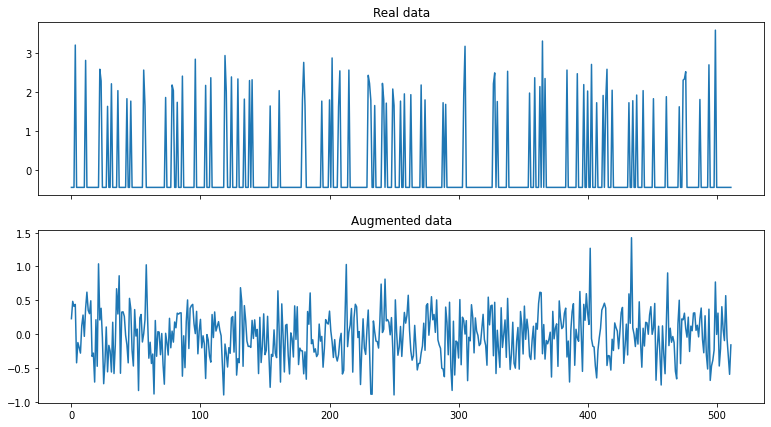

Epoch 401: 0.669 & 0.918
Epoch 402: 0.679 & 0.920
Epoch 403: 0.682 & 0.901
Epoch 404: 0.675 & 0.878
Epoch 405: 0.671 & 0.893
Epoch 406: 0.670 & 0.907
Epoch 407: 0.677 & 0.919
Epoch 408: 0.678 & 0.917
Epoch 409: 0.854 & 0.919
Epoch 410: 0.676 & 0.924
Epoch 411: 0.676 & 1.263
Epoch 412: 0.675 & 0.903
Epoch 413: 0.672 & 0.908
Epoch 414: 0.658 & 0.919
Epoch 415: 0.674 & 0.939
Epoch 416: 0.670 & 0.929
Epoch 417: 0.677 & 0.925
Epoch 418: 0.667 & 0.925
Epoch 419: 0.669 & 0.930
Epoch 420: 0.672 & 0.935
Epoch 421: 0.677 & 0.927
Epoch 422: 0.672 & 0.907
Epoch 423: 0.671 & 0.905
Epoch 424: 0.678 & 0.912
Epoch 425: 0.678 & 0.900
Epoch 426: 0.664 & 0.897
Epoch 427: 0.660 & 0.922
Epoch 428: 0.663 & 0.961
Epoch 429: 0.663 & 0.976
Epoch 430: 0.679 & 0.981
Epoch 431: 0.663 & 0.950
Epoch 432: 0.672 & 1.288
Epoch 433: 0.843 & 0.928
Epoch 434: 0.673 & 0.933
Epoch 435: 0.669 & 0.933
Epoch 436: 0.674 & 0.931
Epoch 437: 3.019 & 0.874
Epoch 438: 0.679 & 0.942
Epoch 439: 0.667 & 0.922
Epoch 440: 0.862 & 0.915


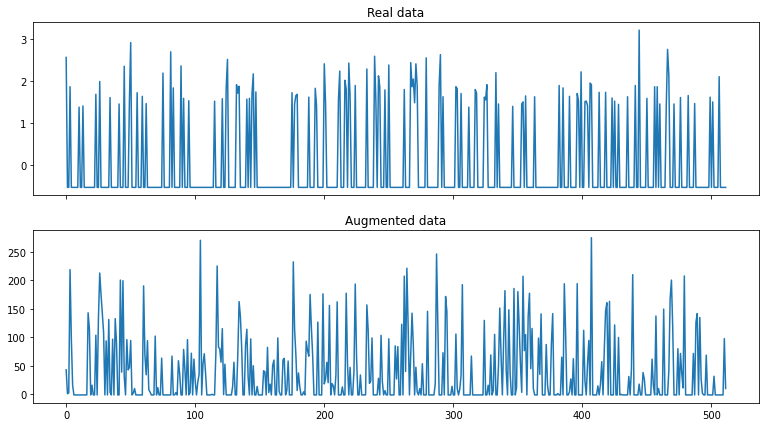

Epoch 451: 0.675 & 0.928
Epoch 452: 0.669 & 1.274
Epoch 453: 0.665 & 0.929
Epoch 454: 0.674 & 0.934
Epoch 455: 0.668 & 1.277
Epoch 456: 0.658 & 0.924
Epoch 457: 0.660 & 0.958
Epoch 458: 0.671 & 0.973
Epoch 459: 0.851 & 0.959
Epoch 460: 0.858 & 0.929
Epoch 461: 0.667 & 0.904
Epoch 462: 0.665 & 0.918
Epoch 463: 0.662 & 0.938
Epoch 464: 0.677 & 0.961
Epoch 465: 0.669 & 0.933
Epoch 466: 0.667 & 0.922
Epoch 467: 0.661 & 0.930
Epoch 468: 0.667 & 1.299
Epoch 469: 0.679 & 0.950
Epoch 470: 0.666 & 0.931
Epoch 471: 0.671 & 0.930
Epoch 472: 0.845 & 0.919
Epoch 473: 0.669 & 0.917
Epoch 474: 0.692 & 0.921
Epoch 475: 0.687 & 0.922
Epoch 476: 0.933 & 0.916
Epoch 477: 0.838 & 0.911
Epoch 478: 0.675 & 0.893
Epoch 479: 0.770 & 1.248
Epoch 480: 0.673 & 0.904
Epoch 481: 0.677 & 0.912
Epoch 482: 0.666 & 1.272
Epoch 483: 0.674 & 0.922
Epoch 484: 0.795 & 0.919
Epoch 485: 0.671 & 0.912
Epoch 486: 0.721 & 0.914
Epoch 487: 0.660 & 0.939
Epoch 488: 0.667 & 0.960
Epoch 489: 0.682 & 0.969
Epoch 490: 0.663 & 0.961


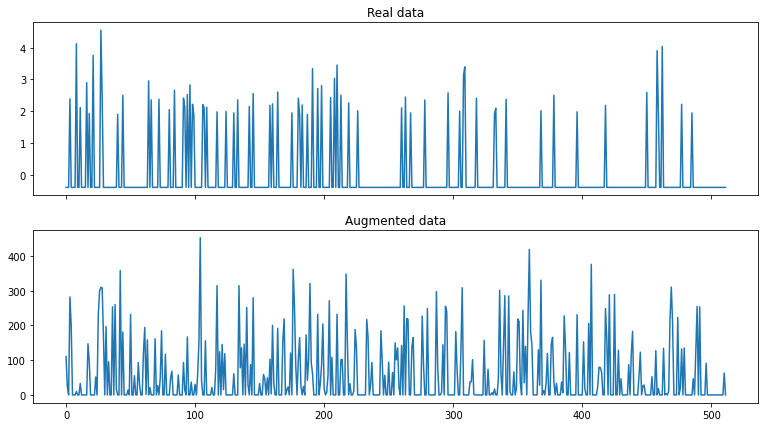

Epoch 501: 0.675 & 0.899
Epoch 502: 0.687 & 0.897
Epoch 503: 0.672 & 0.898
Epoch 504: 0.679 & 0.906
Epoch 505: 0.668 & 0.903
Epoch 506: 0.848 & 0.913
Epoch 507: 0.673 & 0.925
Epoch 508: 0.678 & 0.930
Epoch 509: 0.671 & 0.922
Epoch 510: 0.680 & 0.916
Epoch 511: 0.675 & 0.924
Epoch 512: 0.678 & 0.919
Epoch 513: 0.667 & 0.909
Epoch 514: 0.664 & 0.917
Epoch 515: 3.151 & 0.897
Epoch 516: 8.679 & 0.830
Epoch 517: 0.725 & 0.913
Epoch 518: 0.668 & 0.896
Epoch 519: 0.668 & 0.912
Epoch 520: 0.676 & 0.926
Epoch 521: 0.688 & 0.930
Epoch 522: 0.664 & 0.926
Epoch 523: 0.677 & 0.941
Epoch 524: 0.675 & 0.927
Epoch 525: 0.667 & 0.915
Epoch 526: 0.670 & 0.931
Epoch 527: 0.673 & 0.931
Epoch 528: 0.672 & 0.920
Epoch 529: 0.692 & 0.919
Epoch 530: 0.681 & 0.897
Epoch 531: 0.686 & 0.879
Epoch 532: 0.667 & 0.869
Epoch 533: 7.421 & 0.720
Epoch 534: 7.616 & 2.559
Epoch 535: 0.715 & 0.937
Epoch 536: 0.746 & 0.956
Epoch 537: 0.666 & 0.962
Epoch 538: 0.666 & 0.956
Epoch 539: 0.682 & 0.949
Epoch 540: 0.855 & 0.913


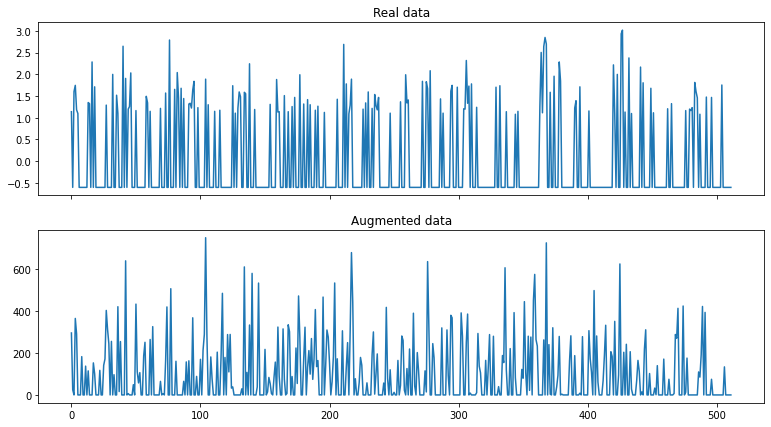

Epoch 551: 0.675 & 0.894
Epoch 552: 0.669 & 0.894
Epoch 553: 0.683 & 0.915
Epoch 554: 0.666 & 0.924
Epoch 555: 0.673 & 0.928
Epoch 556: 9.938 & 0.697
Epoch 557: 1.400 & 3.743
Epoch 558: 0.679 & 0.907
Epoch 559: 0.673 & 0.897
Epoch 560: 0.676 & 0.906
Epoch 561: 0.846 & 0.919
Epoch 562: 0.742 & 0.924
Epoch 563: 0.674 & 0.912
Epoch 564: 0.674 & 0.907
Epoch 565: 0.701 & 0.902
Epoch 566: 0.682 & 0.891
Epoch 567: 0.674 & 0.880
Epoch 568: 0.666 & 0.892
Epoch 569: 0.683 & 0.912
Epoch 570: 0.670 & 0.903
Epoch 571: 0.679 & 0.911
Epoch 572: 0.675 & 0.896
Epoch 573: 0.663 & 0.904
Epoch 574: 0.670 & 0.938
Epoch 575: 0.677 & 0.942
Epoch 576: 0.688 & 0.932
Epoch 577: 0.672 & 0.931
Epoch 578: 0.661 & 0.939
Epoch 579: 0.675 & 0.954
Epoch 580: 0.671 & 0.946
Epoch 581: 0.668 & 0.935
Epoch 582: 0.667 & 0.934
Epoch 583: 0.666 & 0.945
Epoch 584: 0.684 & 0.942
Epoch 585: 0.679 & 0.910
Epoch 586: 0.673 & 0.892
Epoch 587: 0.671 & 0.901
Epoch 588: 0.670 & 0.914
Epoch 589: 0.669 & 0.921
Epoch 590: 0.658 & 0.937


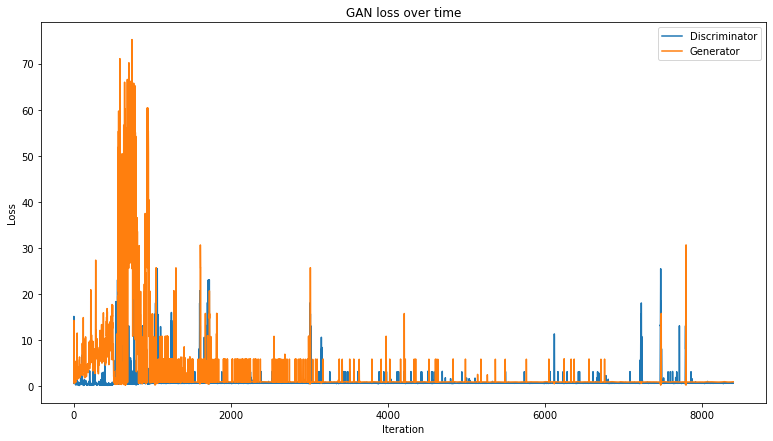

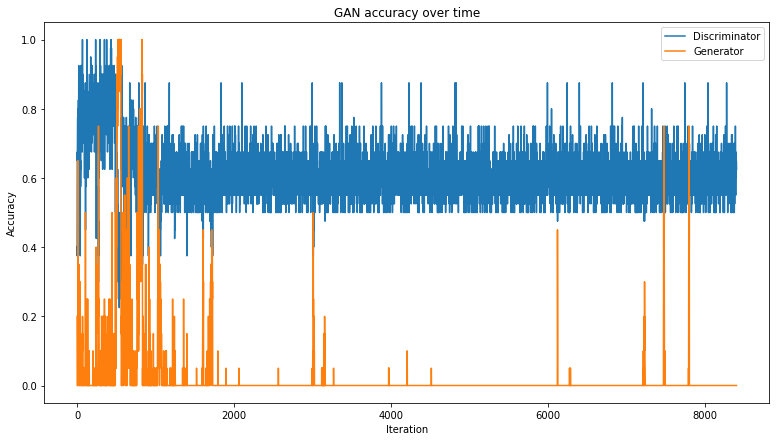

In [ ]:
augmenter0 = DataAugmenter(trainLabel0X)
augmenter0.trainModel(bce=True, epochs=600, batchSize=20, lrD=0.01, lrG=0.01, mixedLabelPct=0.2, verbose=False)
augmenter0.plotLossOverTime()
augmenter0.plotAccuracyOverTime()

## PCA

In [ ]:
def generateAugmentedDataset(augmenter, nObservations, setLowerBound, scaleData):
  augmentedDataset = []
  for i in range(nObservations):
    data = augmenter.generateAugmentedData(setLowerBound)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    data = data.squeeze()
    augmentedDataset.append(data)
  augmentedDataset = np.array(augmentedDataset)
  return augmentedDataset

In [ ]:
def getPCA(dataset):
  pca = PCA(n_components=2)
  components = pca.fit_transform(dataset)
  c1 = components[:, 0]
  c2 = components[:, 1]
  print('Explained variance ratio: {}'.format(pca.explained_variance_ratio_))
  return c1, c2

In [ ]:
def plotPCA(componentsList, colorList, labelList, fileName=None):
  """
  The componentsList should contain a list of tuples. The tuples will contain
  (component1, component2).

  If the fileName parameter is filled, it will save the file. Otherwise,
  it will not be saved.
  """
  plt.figure(figsize=(15,8))
  plt.title('PCA Scatterplot')
  plt.xlabel('PC1')
  plt.ylabel('PC2')

  for i in range(len(componentsList)):
    compTuple = componentsList[i]
    c1 = compTuple[0]
    c2 = compTuple[1]
    color = colorList[i]
    label = labelList[i]
    plt.scatter(c1, c2, color=color, label=label)
  plt.legend()

  if fileName is not None:
    plt.savefig(fileName)

In [ ]:
# Augmentation through the class
augmented1 = augmenter1.generateAugmentedDataset(len(trainLabel1X), True)
augmented0 = augmenter0.generateAugmentedDataset(len(trainLabel0X), True)

In [ ]:
# Augmentation through an outside function
augmented1 = generateAugmentedDataset(augmenter1, len(trainLabel1X), True, False)
augmented0 = generateAugmentedDataset(augmenter0, len(trainLabel0X), True, False)

In [ ]:
# Standardize the original data.
scaler = MinMaxScaler()
trainLabel1X = scaler.fit_transform(trainLabel1X)
trainLabel0X = scaler.fit_transform(trainLabel0X)

Explained variance ratio: [0.01131161 0.01114358]
Explained variance ratio: [0.03140982 0.0293987 ]
Explained variance ratio: [0.7538731  0.24141768]
Explained variance ratio: [1.0000001e+00 2.5516906e-09]


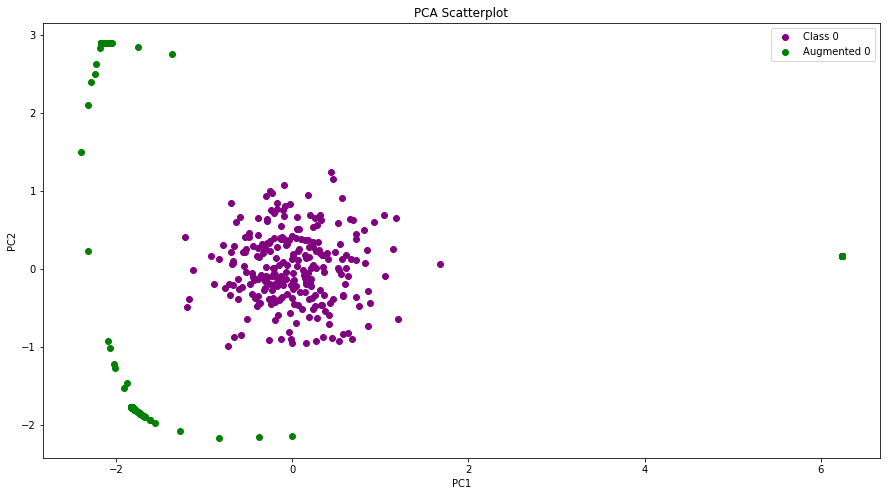

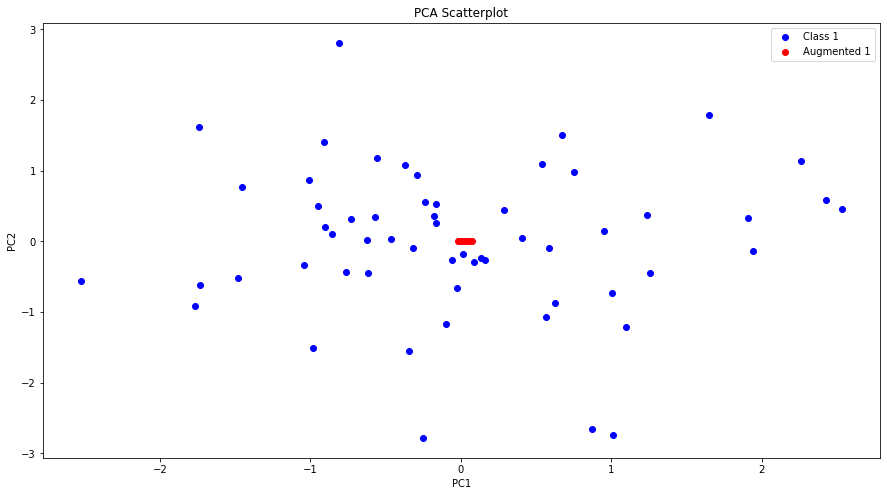

In [ ]:
tuple1 = getPCA(trainLabel0X)
tuple2 = getPCA(trainLabel1X)
tuple3 = getPCA(augmented0)
tuple4 = getPCA(augmented1)

plotPCA([tuple1, tuple3], ['purple', 'green'], ['Class 0', 'Augmented 0'], fileName='Class 0 PCA Transformer.png')
plotPCA([tuple2, tuple4], ['blue', 'red'], ['Class 1', 'Augmented 1'], fileName='Class 1 PCA Transformer.png')

## Create larger datasets through data augmentation

We can see that there are far fewer datasets of class one. That means we need to generate augmented data for that class.

In [ ]:
n = len(trainLabel0X) - len(trainLabel1X)
augmented1 = generateAugmentedDataset(augmenter1, n, True, False)

In [ ]:
# Combine the data.
dfAug = pd.DataFrame(augmented1)
dfTrain1 = pd.DataFrame(trainLabel1X)
dfTrain0 = pd.DataFrame(trainLabel0X)

dfAug['Target'] = 1
dfTrain1['Target'] = 1
dfTrain0['Target'] = 0

combinedDf = pd.concat([dfAug, dfTrain1, dfTrain0], axis=0)

# Separate out X and Y.
combinedDfTrainX = combinedDf.drop(columns=['Target'])
combinedDfTrainY = combinedDf['Target']

In [ ]:
len(combinedDfTrainX)

528

## Evaluate model accuracy on original data

Now fitting logistic regression
Now fitting k-nearest-neighbors
Now fitting random forest classifier


,Hyperparam,Hyperparam val,CV Accuracy,Test Accuracy
Model,,,,
Logistic Regression,C,0.01,0.816779,0.733813
KNN,n_neighbors,21,0.819904,0.748201
Random Forest,n_estimators,-,-,0.748201


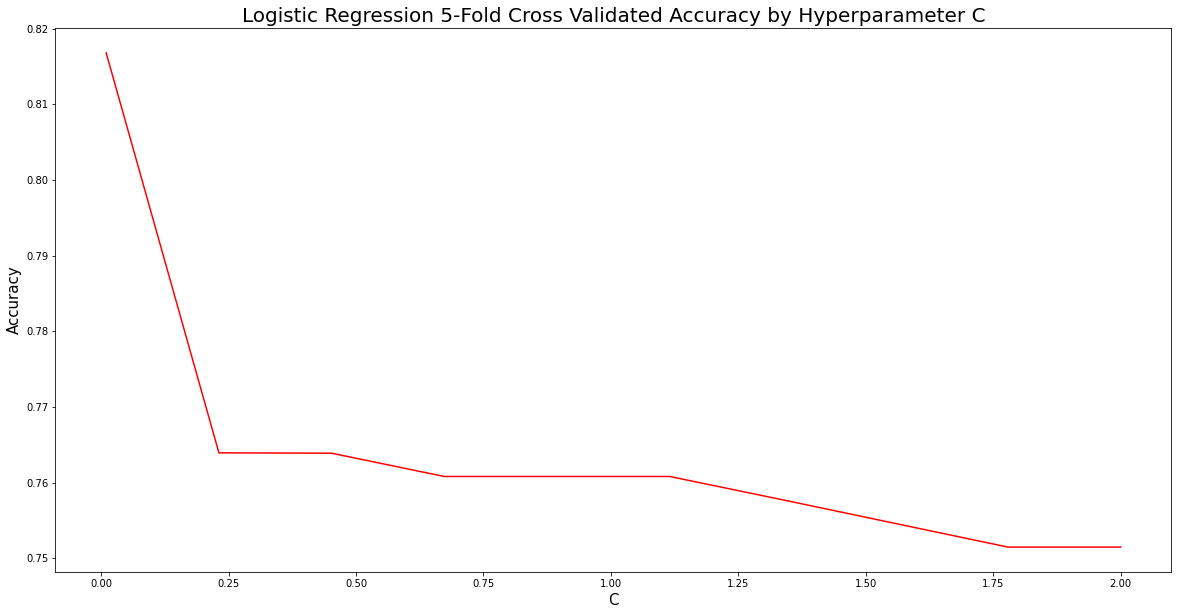

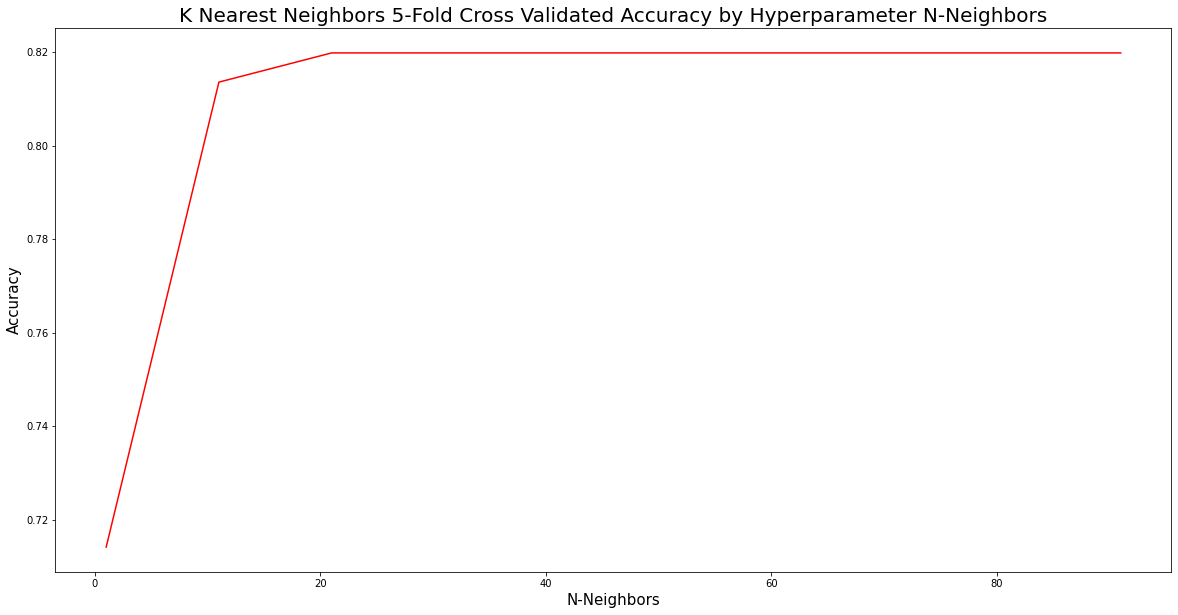

In [ ]:
fitter = automator.AutomaticClassification(trainX, trainY, testX, testY)
reportDf = fitter.main([True, False, True, False, True, False])
reportDf

## Evaluate model accuracy on augmented data

Now fitting logistic regression


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Now fitting k-nearest-neighbors


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Now fitting random forest classifier


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,Hyperparam,Hyperparam val,CV Accuracy,Test Accuracy
Model,,,,
Logistic Regression,C,1.336667,0.893333,0.748201
KNN,n_neighbors,51,0.893333,0.741007
Random Forest,n_estimators,-,-,0.719424


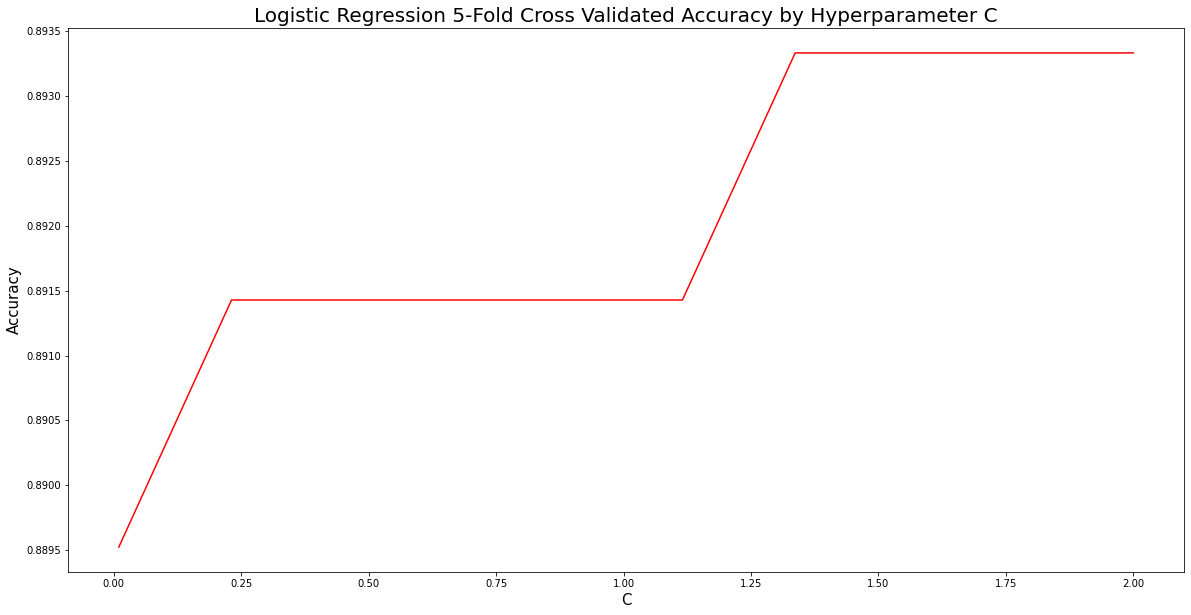

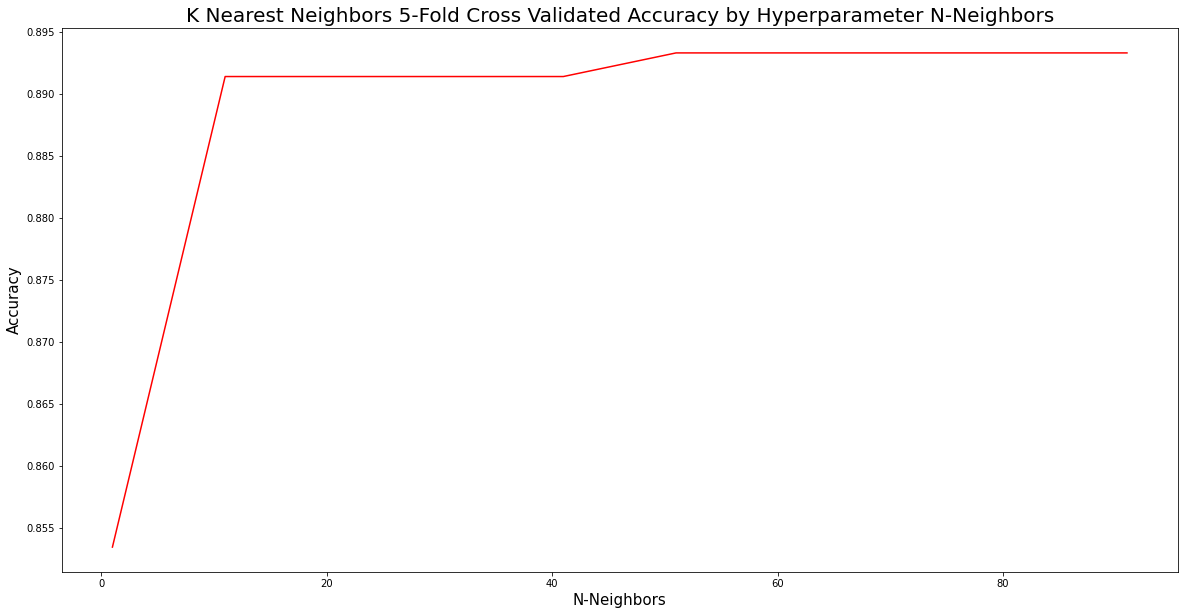

In [ ]:
fitter = automator.AutomaticClassification(combinedDfTrainX, combinedDfTrainY, testX, testY)
reportDf = fitter.main([True, False, True, False, True, False])
reportDf